In [ ]:
### SVM and SVR

In [1]:
# IMPORTS
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# from sklearn.cross_validation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# INIT
number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 4001, 1000))
number_samples = [256, 512, 1024, 2048, 4096]
# number_samples = [30, 60, 90, 120, 150, 180, 210]
C_vec = list(np.arange(1, 1002, 100))
max_txs_number, num_sensors, SENSOR_LOCATION = 1, 400, True
noise_floor = -90.0
DUMMY_LOC_VALUE, DUMMY_POWER_VALUE = noise_floor, noise_floor

In [3]:
# LOAD DATA
num_columns = num_sensors * (3 if SENSOR_LOCATION else 1) + max_txs_number * 3 + 1
cols = [i for i in range(num_columns)]
dataframe = pd.read_csv('../../java_workspace/research/localization/resources/data/' +
                        '50000_1TXs_400sensor_square1000grid_log_alpha2.0_2020_08_16_18_15.txt', 
                        delimiter=',', header=None, names=cols)
dataframe.reset_index(drop=True, inplace=True)

data_reg = dataframe.values
# data_reg[data_reg < noise_floor] = noise_floor
del dataframe

In [54]:
data_reg[data_reg < noise_floor] = noise_floor

(array([1.000e+01, 3.300e+01, 7.900e+01, 1.670e+02, 2.710e+02, 3.690e+02,
        4.800e+02, 5.720e+02, 7.050e+02, 8.080e+02, 8.400e+02, 9.320e+02,
        1.035e+03, 1.040e+03, 1.132e+03, 1.165e+03, 1.184e+03, 1.190e+03,
        1.219e+03, 1.259e+03, 1.326e+03, 1.341e+03, 1.265e+03, 1.351e+03,
        1.376e+03, 1.363e+03, 1.374e+03, 1.310e+03, 1.405e+03, 1.312e+03,
        1.401e+03, 1.357e+03, 1.391e+03, 1.425e+03, 1.318e+03, 1.452e+03,
        1.331e+03, 1.369e+03, 1.353e+03, 1.183e+03, 1.104e+03, 1.002e+03,
        8.880e+02, 7.910e+02, 6.990e+02, 6.300e+02, 4.980e+02, 4.540e+02,
        4.170e+02, 3.530e+02, 3.050e+02, 2.360e+02, 1.910e+02, 1.440e+02,
        1.250e+02, 9.100e+01, 8.400e+01, 7.500e+01, 6.500e+01, 5.600e+01,
        6.200e+01, 3.700e+01, 4.100e+01, 3.000e+01, 2.600e+01, 1.400e+01,
        1.300e+01, 1.600e+01, 5.000e+00, 9.000e+00, 1.100e+01, 9.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+0

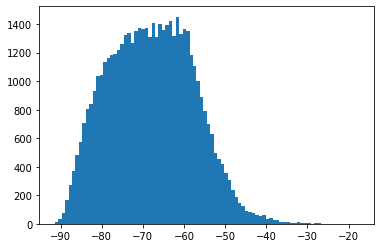

In [4]:
plt.hist(data_reg[:,2:3:num_sensors*3], bins='auto')

In [17]:
# LOAD DATA for testbed
num_columns = (num_sensors if IS_SENSORS else max_pus_number * 3 + 1) + max_sus_number * 3 + 1
cols = [i for i in range(num_columns)]
dataframe = pd.read_csv('ML/data/' + 'testbed_ss_1_shuf', 
                        delimiter=',', header=None, names=cols)
dataframe.reset_index(drop=True, inplace=True)
data_reg = dataframe.values
data_reg[data_reg<-90] = -90

In [12]:
data_reg[0]

array([747.   , 106.   , -73.303, ..., 816.   , 496.   , -22.291])

In [20]:
selected_columns = [12, 2, 0, 9, 14]
droped_columns = []
for i in range(18):
    if i not in selected_columns:
        droped_columns.append(i)
data_reg = np.delete(data_reg, droped_columns, 1)
num_sensors = 5
num_columns = (num_sensors if IS_SENSORS else max_pus_number * 3 + 1) + max_sus_number * 3 + 2

In [5]:
# Splitting data
# def split_data(data, train_samples):
#     num_inputs = data.shape[1] - 1
#     val_samples = round(train_samples/3)
#     X_train, y_train = data[0:train_samples, 0: num_inputs], data[0:train_samples, -1]
#     X_val, y_val = data[train_samples:train_samples+val_samples, 0: num_inputs],data[train_samples:train_samples+val_samples, -1]
#     X_test, y_test = data[train_samples:, 0: num_inputs], data[train_samples:, -1]
#     return X_train,X_val, X_test, y_train, y_val, y_test

def split_data(data: np.ndarray, train_samples, target:'str'):
    num_inputs = num_sensors if not SENSOR_LOCATION else 3 * num_sensors
    val_samples = round(train_samples/3)
    test_samples = data.shape[0] - val_samples - train_samples
    #init arrays
    X_train = np.ones((train_samples, num_inputs), dtype=float) * DUMMY_LOC_VALUE
    X_val = np.ones((val_samples, num_inputs), dtype=float) * DUMMY_LOC_VALUE
    X_test = np.ones((test_samples, num_inputs), dtype=float) * DUMMY_LOC_VALUE
    # read values
    X_train[:, :num_inputs] = data[:train_samples, :num_inputs]
    X_val[:, :num_inputs] = data[train_samples:train_samples + val_samples, :num_inputs]
    X_test[:, :num_inputs] = data[train_samples + val_samples: , :num_inputs]
    # TODO: multi-tx support is missing
    y_pos = 0;
    if target in ['x', 'X']:
        y_pos = -3
    elif target in ['y', 'Y']:
        y_pos = -2
    else:
        y_pos = -1
        
    y_train = data[0 : train_samples, y_pos]
    y_val = data[train_samples : train_samples + val_samples, y_pos]
    y_test = data[train_samples + val_samples:, y_pos]
    return X_train,X_val, X_test, y_train, y_val, y_test

In [11]:
#utils
def false_analysis(y_test, y_pred):
    tp = sum(y_pred[y_test==1])
    fp = sum(y_pred) - tp
    return fp, sum(y_test) - tp

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, 20, 'p')
print(data_reg[0])
print(X_train[0])
print(y_train[0])
print("***")
print(data_reg[20])
print(X_val[0])
print(y_val[0])
print("***")
print(data_reg[27])
print(X_test[0])
print(y_test[0])

[490.    570.    -81.531 ... 110.    448.    -29.509]
[490.    570.    -81.531 ... 388.    717.    -81.26 ]
-29.509
***
[988.    617.    -78.303 ... 501.    673.    -24.496]
[988.    617.    -78.303 ... 582.    693.    -62.922]
-24.496
***
[302.    714.    -65.28  ... 123.    153.     -9.879]
[302.    714.    -65.28  ... 788.    994.    -70.484]
-9.879


In [7]:
X_val.shape

(7, 1200)

In [29]:
max(data_reg[0][0:num_sensors])

-49.678999999999995

In [25]:
C_vec

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001]

In [51]:
number_samples = [512, 1024, 2048, 4096]

In [8]:
# SVR
average_reg_diff_power, best_c_reg_lst, fp_mean_power, averae_dist_error = [], [], [], []
for number_sample in number_samples:
    best_c_reg_dic = {}
    y_test_dic, y_pred_dic = {}, {}
    for target in ['x', 'y', 'power']:
        min_err = float('inf')
        best_c_reg, bestsvrclassifier =  None, None
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, number_sample, target)
        y_test_dic[target] = y_test
        #training
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_val = scaler_x.transform(X_val)
        for c in C_vec:
            svrlassifier = SVR(kernel='rbf', C=c, degree=X_train.shape[1]+1)
            svrlassifier.fit(X_train, y_train)

            #validating
            y_pred_val = svrlassifier.predict(X_val)
            err_tmp = np.mean(np.absolute(y_pred_val - y_val))
            if err_tmp < min_err:
                min_err = err_tmp
                best_c_reg = c
                bestsvrclassifier = svrlassifier
        
        best_c_reg_dic[target] = best_c_reg
        #predicting
        X_test = scaler_x.transform(X_test)
        y_pred = bestsvrclassifier.predict(X_test)
        y_pred_dic[target] = y_pred


        #evaluating
        if target == 'power':
            average_reg_diff_power.append(round(np.mean(np.absolute(y_test - y_pred)), 3))
#             fp_samples = np.zeros(len(y_test), dtype=float)
#             fp_samples[y_pred > y_test] = (y_pred - y_test)[y_pred > y_test]
#             fp_mean_power.append(round(np.mean(fp_samples), 3))
    dist_error = np.round(np.mean(np.sqrt(np.power(y_pred_dic['x'] - y_test_dic['x'], 2) + 
                                         np.power(y_pred_dic['y'] - y_test_dic['y'], 2))), 3)
    averae_dist_error.append(dist_error)
    best_c_reg_lst.append(best_c_reg_dic)
    print('Number_samples: ', number_sample, 'power error: ', average_reg_diff_power[-1], 
         'distance error: ', averae_dist_error[-1])

Number_samples:  256 power error:  1.392 distance error:  384.308
Number_samples:  512 power error:  1.285 distance error:  383.106


KeyboardInterrupt: 

In [25]:
data_reg[:,:num_sensors*3].shape

(50000, 1200)

In [23]:
svrlassifier.degree

1201

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, 256, 'x')
scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_val = scaler_x.transform(X_val)
svrlassifier = SVR(kernel='sigmoid', C=0.1, degree=X_train.shape[1]+1)
svrlassifier.fit(X_train, y_train)
X_test = scaler_x.transform(X_test)
y_pred = svrlassifier.predict(X_test)
print(np.mean(np.absolute(y_pred - y_test)))


[LibSVM]251.39651675422618


In [26]:
data_reg

array([[ 3.3100e+02,  2.3300e+02, -6.2118e+01, ...,  4.8800e+02,
         1.7500e+02, -1.7644e+01],
       [ 6.9500e+02,  5.4900e+02, -8.1566e+01, ...,  2.7000e+01,
         6.2200e+02, -2.5019e+01],
       [ 8.6700e+02,  4.5800e+02, -6.6108e+01, ...,  9.0400e+02,
         8.5000e+01, -1.4632e+01],
       ...,
       [ 4.0000e+01,  2.6200e+02, -5.9186e+01, ...,  8.9400e+02,
         3.1800e+02, -5.3800e-01],
       [ 2.5100e+02,  8.6900e+02, -7.9184e+01, ...,  5.2500e+02,
         2.7600e+02, -2.2883e+01],
       [ 4.9200e+02,  5.7600e+02, -6.8531e+01, ...,  7.0200e+02,
         8.1600e+02, -1.8458e+01]])

In [10]:
best_c_reg_lst

[{'x': 101, 'y': 1, 'power': 101}, {'x': 1, 'y': 1, 'power': 101}]

# noise_floor = -90
Number_samples:  256 power error:  1.355 distance error:  383.626
Number_samples:  512 power error:  1.262 distance error:  383.798
Number_samples:  1024 power error:  1.177 distance error:  383.401
Number_samples:  2048 power error:  1.136 distance error:  383.386

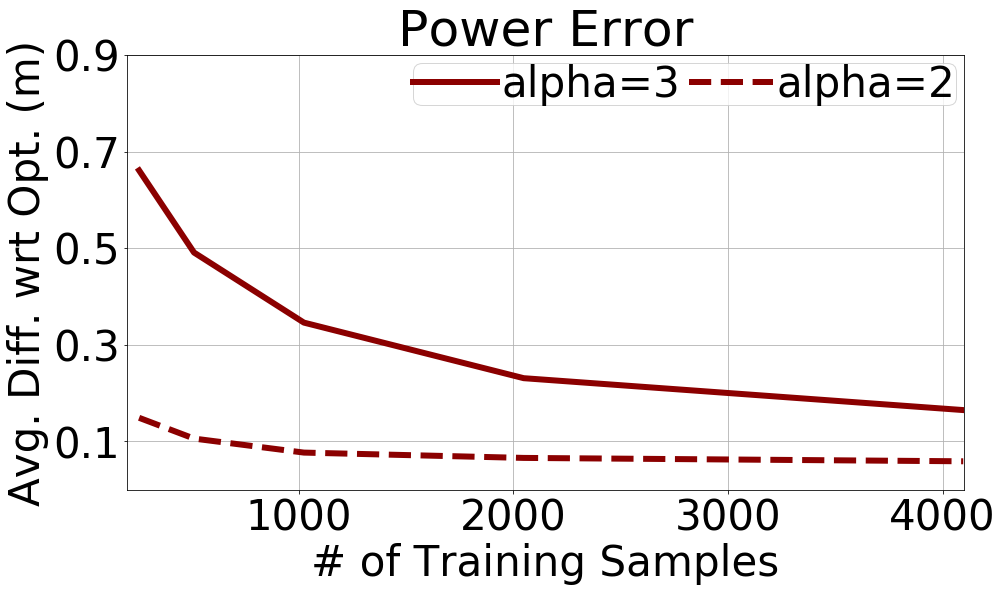

In [15]:
### MAX_POWER ANAlysis, Using SSs
# Effect of changing sensor set size, 210 training sample
#variable training samples, , field 10*10, validation samples training/5, test samples few
# dynamic pus(number of pus is changing),  field 10*10
# data_sets = {"testbed_ss_1_shuf"}
# comparing CNN and previous machine learning algos using pu info.
# number_samples = [30, 60, 90, 120, 150, 180, 210] 

power_error = []
dist_error = []
training_samples = [256, 512, 1024, 2048, 4096]  


#0: noise_floor = -90, 1600 sensors
power_error.append([0.661, 0.491, 0.346, 0.231, 0.165]) # no noise, alpha=3
dist_error.append([82.39, 61.85, 46.61, 34.81, 25.31]) # no noise, alpha=3

#1: no noise_floor, 1600 sensors
power_error.append([0.211, 0.133, 0.09, 0.07, 0.06])  # no noise, alpha=3
dist_error.append([9.9, 5.21, 2.499, 1.512, 1.09])    # no noise, alpha=3

#2: no noise, nf=-90, alpha = 2, 1600 sensors
power_error.append([0.149, 0.106, 0.077, 0.066, 0.059])
dist_error.append([11.299, 5.763, 3.442, 2.049, 1.268])

#3: std=1.0, nf=-90, alpha=2, 400 uniform sensors
power_error.append([0.254, 0.191, 0.15, 0.13, 0.115])
dist_error.append([18.49, 14.81, 12.74, 11.4, 9.95])

#4: std=1.0, nf=-90, alpha=2, 1600 uniform sensors
power_error.append([0.217, 0.153, 0.107, 0.082, 0.067])
dist_error.append([17.44, 11.8, 8.38, 6.92, 6.18])



line_width = 6
marker_size = 10
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
# plt.plot(training_samples, average_diff[0], color='r', linewidth=line_width, markersize=marker_size, linestyle=reg_style)
plt.plot(training_samples, power_error[0], color='darkred',  #midnightblue, darkred
         linewidth=line_width, markersize=marker_size, linestyle=reg_style)
plt.plot(training_samples, power_error[2], color='darkred', linewidth=line_width,
         markersize=marker_size, linestyle=class_reg)
# plt.plot(training_samples, average_diff[2], color='darkgreen', linewidth=line_width,
#          markersize=marker_size, linestyle=reg_style)
# plt.plot(training_samples, average_diff[4], color='darkorange', linewidth=line_width,
#          markersize=marker_size, linestyle=reg_style)
plt.xlabel('# of Training Samples', fontsize=42)
plt.ylabel('Avg. Diff. wrt Opt. (m)', fontsize=42)
plt.title('Power Error')
plt.grid(True)

ax.set_yticks(np.arange(0.1, 1, 0.2))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=42)
ax.tick_params(axis='y', labelsize=42)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([0, 0.9])
ax.set_xlim([200, 4100])
plt.legend([ 'alpha=3', 'alpha=2'], ncol=3, loc='best', handletextpad=0.1,
           borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('results/field1000_alpha3_no_noise_1600sensors_power_error_nf.png', 
            bbox_inches = 'tight', pad_inches = 0)

In [24]:
# LinearSVR
average_reg_diff_power, best_c_reg_lst, fp_mean_power, averae_dist_error = [], [], [], []
for number_sample in number_samples:
    best_c_reg_dic = {}
    y_test_dic, y_pred_dic = {}, {}
    for target in ['x', 'y', 'power']:
        min_err = float('inf')
        best_c_reg, bestsvrclassifier =  None, None
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, number_sample, target)
        y_test_dic[target] = y_test
        #training
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_val = scaler_x.transform(X_val)
        for c in C_vec:
            svrlassifier = LinearSVR(C=c, loss='epsilon_insensitive')
            svrlassifier.fit(X_train, y_train)

            #validating
            y_pred_val = svrlassifier.predict(X_val)
            err_tmp = np.mean(np.absolute(y_pred_val - y_val))
            if err_tmp < min_err:
                min_err = err_tmp
                best_c_reg = c
                bestsvrclassifier = svrlassifier
        
        best_c_reg_dic[target] = best_c_reg
        #predicting
        X_test = scaler_x.transform(X_test)
        y_pred = bestsvrclassifier.predict(X_test)
        y_pred_dic[target] = y_pred


        #evaluating
        if target == 'power':
            average_reg_diff_power.append(round(np.mean(np.absolute(y_test - y_pred)), 3))
#             fp_samples = np.zeros(len(y_test), dtype=float)
#             fp_samples[y_pred > y_test] = (y_pred - y_test)[y_pred > y_test]
#             fp_mean_power.append(round(np.mean(fp_samples), 3))
    dist_error = np.round(np.mean(np.sqrt(np.power(y_pred_dic['x'] - y_test_dic['x'], 2) + 
                                         np.power(y_pred_dic['y'] - y_test_dic['y'], 2))), 3)
    averae_dist_error.append(dist_error)
    best_c_reg_lst.append(best_c_reg_dic)
    print('Number_samples: ', number_sample, 'power error: ', average_reg_diff_power[-1], 
         'distance error: ', averae_dist_error[-1])

Number_samples:  256 power error:  1.151 distance error:  394.547


KeyboardInterrupt: 

In [15]:
print(average_reg_diff_power)
print(fp_mean_power)

[13.66, 9.952, 7.887, 8.077, 8.125, 6.643, 6.83]
[5.692, 1.234, 3.923, 3.047, 4.302, 3.164, 4.037]


In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_class_diff_power)
plt.plot(number_samples, average_reg_diff_power, 'r--')
plt.xlabel('# training samples')
plt.ylabel('Diff(dB)')
plt.title('Average absolute difference power(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)

ax.set_yticks(np.arange(0,20, 2))
ax.set_ylim([2,20])
ax.set_xticks(np.arange(5,4100, 500))
# plt.grid(which='minor')
# plt.text(40, 50, '# Validation = 34k')
# plt.text(400, 45, '# Test = 34k')
plt.legend(['SVM', 'SVR'])
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_averag_powerSVMSVR.png')

In [ ]:
average_reg_diff_power_tot = []


In [ ]:
print(number_samples)

In [ ]:
average_reg_diff_power_tot.append(average_reg_diff_power)

In [ ]:
## SVM(SVC)
average_class_diff_power = []
fp_mean_power = []
accuracy, f_score, false_positive, false_negative = [], [], [], []
best_c_lst = []
fp_penalty_coef, fn_penalty_coef = 1, 1
metric = "fp_min"  # {"accuracy", "fp_min"}
class_weight = {0:fp_penalty_coef/(fp_penalty_coef + fn_penalty_coef), 1:fn_penalty_coef/(fp_penalty_coef + fn_penalty_coef)}
best_c, bestsvcclassifier = None, None
for number_sample in number_samples:
    best_accuracy = -float('inf')
    best_fp = float('inf')
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_class, number_sample)
    scaler_x = StandardScaler()
    scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_val = scaler_x.transform(X_val)
    for c in C_vec:
        svclassifier = SVC(kernel='rbf', C=c, class_weight = class_weight)
        svclassifier.fit(X_train, y_train)
        
        #validating
        y_pred_val = svclassifier.predict(X_val)
        if metric == "accuracy":
            accuracy_tmp = metrics.accuracy_score(y_val, y_pred_val)
            if accuracy_tmp > best_accuracy:
                best_accuracy = accuracy_tmp
                best_c = c
                bestsvcclassifier = svclassifier
        elif metric == "fp_min":
            conf_mat = metrics.confusion_matrix(y_val, y_pred_val)
            fp_tmp = conf_mat[0][1] if len(conf_mat) == 2 else 0
            if fp_tmp < best_fp:
                best_fp = fp_tmp
                best_c = c
                bestsvcclassifier = svclassifier
                    
            
    best_c_lst.append(best_c)
    #predicting
    X_test = scaler_x.transform(X_test)
    y_pred = bestsvcclassifier.predict(X_test)
    
    #evaluating
    accuracy.append(round(metrics.accuracy_score(y_test, y_pred), 3))
    f_score.append(round(metrics.f1_score(y_true=y_test, y_pred=y_pred), 3))
    fp, fn = false_analysis(y_test, y_pred)
    false_positive.append(int(fp))
    false_negative.append(int(fn))
    
    #Power max calculations
    y_class_power_test = y_class_power[len(y_class_power)-X_test.shape[0]:]
    y_class_power_pred = np.zeros(y_class_power_test.size)
    max_power = max(y_class_power_test) + 10  # 10 is added to increase higher bound
    min_power = min(y_class_power_test) - 10  # 10 is subtracted to decrease lower bound
    for i in range(len(y_class_power_test)):
        h = max_power
        l = min_power
        while h - l > 0.5:
            mid = l + (h - l)/2;
            mid_norm = (mid - scaler_x.mean_[-1])/scaler_x.scale_[-1]
            X_test[i][-1] = mid_norm
            res_tmp = bestsvcclassifier.predict(X_test[i:i+1])
            if res_tmp[0]:
                l = mid
            else:
                h = mid
        y_class_power_pred[i] = l + (h - l)/2
    average_class_diff_power.append(round(np.mean(np.absolute(y_class_power_pred - y_class_power_test)), 3))
    fp_samples = np.zeros(len(y_class_power_pred), dtype=float)
    fp_samples[y_class_power_pred > y_class_power_test] = (y_class_power_pred - y_class_power_test)[y_class_power_pred > 
                                                                                                    y_class_power_test]
    fp_mean_power.append(round(np.mean(fp_samples), 3))
    print('Number_samples:', number_sample, ', accuracy:', accuracy[-1], ', f_score:', f_score[-1], 
          ', fp:', fp,', fn:', fn, ', error:', average_class_diff_power[-1], 'fp_error:', fp_mean_power[-1])
del svclassifier

In [ ]:
print(average_class_diff_power)
print(fp_mean_power)

In [ ]:
### MAX_POWER ANAlysis
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, accuracy)
plt.xlabel('# training samples')
plt.ylabel('%')
plt.title('SVM: Classification Accuracy(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmAcc.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, f_score)
plt.xlabel('# training samples')
plt.ylabel('%')
plt.title('SVM: Classification F_score(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfscore.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, false_positive)
plt.xlabel('# training samples')
plt.ylabel('#')
plt.title('SVM: Classification FP(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfp.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, false_negative)
plt.xlabel('# training samples')
plt.ylabel('#')
plt.title('SVM: Classification FN(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfn.png')

In [ ]:
number_samples = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400, 500, 700, 1000, 2000, 3000, 4000]
average_reg_diff_power_tot = [[4.91, 4.915, 5.02, 7.274, 5.21, 5.476, 5.547, 5.448, 5.358, 5.486, 5.424, 5.585, 5.423, 5.369,
                               5.275, 5.22, 5.065, 5.058, 4.915, 4.873, 4.8, 4.787, 4.782], 
                              [4.739, 4.728, 4.858, 4.9, 4.761, 4.835, 4.898, 4.959, 4.806, 4.913, 4.945, 4.88, 4.8, 4.812,
                               4.756, 4.74, 4.764, 4.832, 4.729, 4.745, 4.728, 4.728, 4.731], 
                              [5.59, 5.33, 4.764, 4.731, 4.728, 4.923, 5.086, 4.798, 4.816, 5.035, 4.827, 4.842, 4.757, 4.796,
                               4.734, 4.748, 4.74, 4.734, 4.728, 4.729, 4.726, 4.726, 4.728], 
                              [4.791, 4.781, 4.732, 5.677, 4.757, 4.837, 4.841, 5.242, 4.81, 4.955, 4.972, 5.106, 4.801, 4.754,
                               4.764, 4.748, 4.757, 4.763, 4.737, 4.735, 4.737, 4.74, 4.744]]

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_reg_diff_power_tot[0])
plt.plot(number_samples, average_reg_diff_power_tot[1], 'r--')
plt.plot(number_samples, average_reg_diff_power_tot[2], 'g.-')
plt.plot(number_samples, average_reg_diff_power_tot[3], 'y->')
plt.xlabel('# training samples')
plt.ylabel('Diff(dB)')
plt.title('Average absolute difference power(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)

ax.set_yticks(np.arange(0,8, 2))
ax.set_ylim([2,8])
ax.set_xticks(np.arange(5,4100, 500))
# plt.grid(which='minor')
# plt.text(40, 50, '# Validation = 34k')
# plt.text(400, 45, '# Test = 34k')
plt.legend(['linear', 'rbf', 'poly', 'sigmoid'])
# plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_averag_powerSVMSVR.png')